In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import sys

sys.path.insert(0, str(Path("../../").resolve()))

from src.features import create_feature_frame, generate_target
from src.models import train_test_split, feature_label_split, baseline

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Feature frame
from src.load import load_parcelas_feature_frame
from src.load_meteo import load_meteo_feature_frame
# Evaluation metrics
from src.metrics import evaluate_classification, log_metrics, evaluate_configuration, evaluate_configuration_lightgbm

plt.style.use('ggplot')

In [2]:
df_parcelas = load_parcelas_feature_frame()
df_meteo = load_meteo_feature_frame()

INFO:root:Executing load_parcelas_feature_frame
INFO:root:Loading dataset from /Users/jianingxu/Documents/repositories/courses/zrive-ds-1q24-olive-stage-prediction/src/notebooks_jianing/../../data/parcelas_feature_frame.parquet
INFO:root:Executing load_meteo_feature_frame
INFO:root:Loading dataset from /Users/jianingxu/Documents/repositories/courses/zrive-ds-1q24-olive-stage-prediction/src/notebooks_jianing/../../data/meteo_feature_frame.parquet


In [3]:
def preprocess_data(columns_parcela: list[str], columns_meteo: list[str]):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"

    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )

    # LOCF for weather indices
    feature_frame["fecha"] = pd.to_datetime(feature_frame["fecha"])
    feature_frame.sort_values(by=["codparcela", "fecha"], inplace=True)
    feature_frame.set_index("fecha", inplace=True)
    feature_frame[columns_meteo] = feature_frame.groupby("codparcela")[columns_meteo].fillna(method="ffill")
    feature_frame.reset_index(inplace=True)

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)


    numerical_processor = Pipeline(
        steps=[
            ("imputation_mean", SimpleImputer(strategy="mean")),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("impute", numerical_processor, columns_parcela + columns_meteo),
        ]
    )


    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    # Use get_feature_names_out to get the transformed column names
    transformed_names = preprocessor.get_feature_names_out()

    # Create DataFrames with the transformed names
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=transformed_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=transformed_names)

    return X_train_preprocessed, pd.Series(y_train), X_test_preprocessed, pd.Series(y_test)

In [4]:
def preprocess_data_lightgbm(columns_parcela: list[str], columns_meteo: list[str]):
    SPLIT_YEAR = 2021
    MAX_YEAR = 2022
    LABEL_COL = "target"

    feature_frame = create_feature_frame(
        df_parcelas, df_meteo, columns_parcela, columns_meteo
    )

    feature_frame["fecha"] = pd.to_datetime(feature_frame["fecha"])
    feature_frame = feature_frame[columns_parcela + columns_meteo + [LABEL_COL, "fecha"]]

    train_df, test_df = train_test_split(
        feature_frame, split_year=SPLIT_YEAR, max_year=MAX_YEAR
    )

    train_df.drop(columns=["fecha", "year"], inplace=True)
    test_df.drop(columns=["fecha", "year"], inplace=True)

    X_train, y_train = feature_label_split(train_df, LABEL_COL)
    X_test, y_test = feature_label_split(test_df, LABEL_COL)

    return X_train, y_train, X_test, y_test

In [5]:
evaluation_metrics = {}
models = {}

def save_model(model: Pipeline, model_name: str, models: dict):
    models[model_name] = model

In [6]:
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")


def train_lightgbm_model(X_train, y_train, X_test, y_test, params: dict):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

    eval_result = {}

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_test, lgb_train],
        callbacks=[lgb.record_evaluation(eval_result=eval_result)],
    )
    return model, eval_result

In [7]:
import shap


def get_shap_values(model, X_test):
    explainer = shap.Explainer(model)
    fn = model.feature_name()
    shap_values = explainer(X_test[fn])
    shap_values = shap_values[:, :, 1]
    return shap_values


def plot_shap_feature_importance(shap_values, top_n=15):
    plt.title("SHAP Feature importance for lightgbm model")
    shap.plots.bar(shap_values, max_display=top_n)

# Selecting features using SHAP

In [8]:
### I won't use columns with more than 80% of nulls
label_col = 'target'

PHENOLOGICAL_STATE_COLS = [f"estado_fenologico_{i}" for i in range(14, 0, -1)]

parcelas_numerical_cols = ['campaña','porcentaje_floracion','102_coordenada_x_(utm)',
        '103_coordenada_y_(utm)', '104_altitud_(m)','201_superf_cultivada_en_la_parcela_agrícola_(ha)',
        '202_pendiente_(%)', '302_densidad_(plantas_ha)', '303_nº_pies_por_árbol',
        '305_diámetro_de_copa_(m)','317_%_superficie_ocupada_variedad_secundaria',
        '306_altura_de_copa_(m)', 'estado_mayoritario']

parcelas_categorical_cols = ['codparcela', '105_comarca', '203_orientación', '204_textura_del_suelo',
       '206_secano_/_regadío', '211_utilización_de_cubierta_vegetal',
       '212_tipo_de_cubierta_vegetal',
       '214_cultivo_asociado/otro_aprovechamiento', '301_marco_(m_x_m)',
       '304_formación', '308_variedad_principal',
       '311_fecha_de_plantación_variedad_principal',
       '208_riego:_procedencia_del_agua', '209_riego:_calidad_del_agua',
       '313_variedad_secundaria', '107_zona_homogénea',
       '120_zona_biológica_raif', '401_estación_climática_asociada',
       '402_sensor_climático_asociado', '207_riego:_sistema_usual_de_riego',
       '108_u_h_c_a_la_que_pertenece',
       '316_fecha_de_plantación_variedad_secundaria',
       '315_patrón_variedad_secundaria', '310_patrón_variedad_principal',
       '411_representa_a_la_u_h_c_(si/no)',
       '109_sistema_para_el_cumplimiento_gestión_integrada']

parcelas_created_features_cols = ['week_number', 'days_in_current_state', 'days_in_previous_state']


# meteo_numerical_cols = ['lat', 'lon', 'FAPAR', 'GNDVI', 'LST',
#                          'NDVI', 'NDWI', 'SAVI', 'SIPI', 'SSM']


METEO_COLUMNS = ["FAPAR", "GNDVI", "LST", "NDVI", "NDWI", "SAVI", "SIPI", "SSM"]
DAYS = ["365D", "90D"]
STATS = ["count", "mean", "std", "min", "median", "max"]
meteo_stats_cols = [f"{col}_{stat}_{day}" for col in METEO_COLUMNS for day in DAYS for stat in STATS]

In [9]:
selected_parcelas_cols = parcelas_numerical_cols + parcelas_created_features_cols
selected_meteo_cols = meteo_stats_cols
X_train, y_train, X_test, y_test = preprocess_data_lightgbm(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17085
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 112
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lightgbm_all_features_train:
INFO:src.metrics:accuracy: 0.8387480046437382
INFO:src.metrics:mse: 0.17316064431867653
INFO:src.metrics:precision_for_class: [0.91185923 0.76321572 0.73609525 0.89780521]
INFO:src.metrics:recall_for_class: [0.89972449 0.80196391 0.70460578 0.63698297]
INFO:src.metrics:f1_for_class: [0.90575122 0.78211018 0.72000638 0.745232  ]
INFO:src.metrics:confusion_matrix:
[[51924  5643   141     3]
 [ 4922 30218  2513    27]
 [   96  3569  9026   119]
 [    1   163   582  1309]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lightgbm_all_features_test:
INFO:src.metrics:accuracy: 0.7309996846420688
INFO:src.metrics:mse: 0.32896337342884174
INFO:src.metrics:precision_for_class: [0.86498625 0.64463233 0.54160126 0.40407288]
INFO:src.metrics:recall_for_class: [0.82297026 0.68640022 0.51550243 0.52216066]
INFO:src.metrics:f1_for_class: [0.84345533 0.66486094 0.52822967 0.45558912]
INFO:src.me

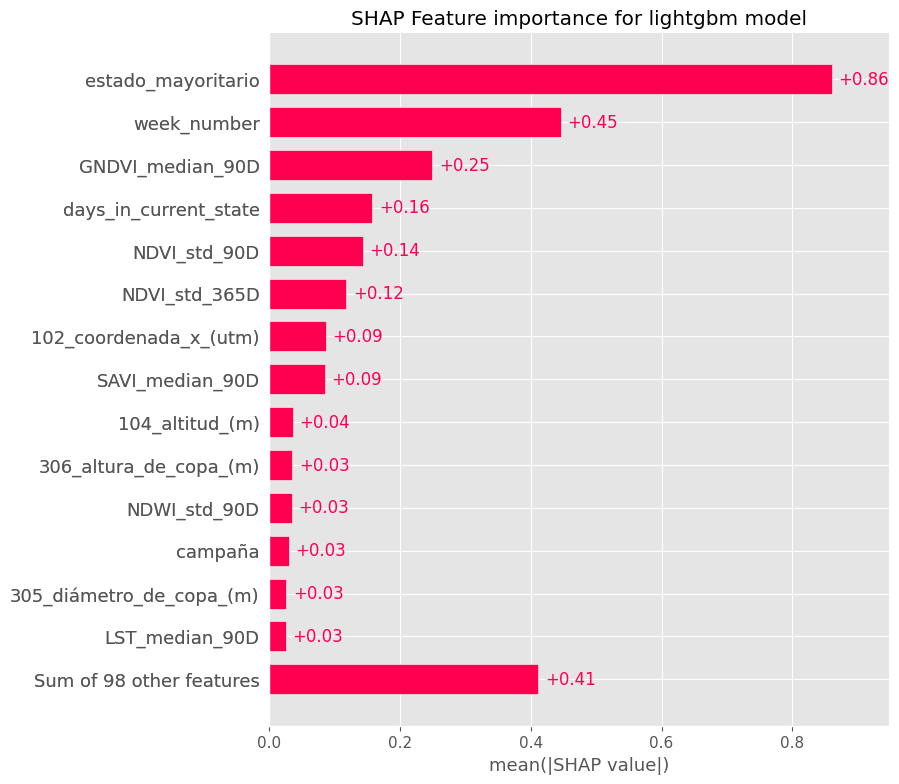

In [10]:
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": len(np.unique(y_train)),
    "num_trees": 100,

    "learning_rate": 0.1,
}
model_name = "lightgbm_all_features"
model, eval_result = train_lightgbm_model(X_train, y_train, X_test, y_test, params)
evaluate_configuration_lightgbm(model, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
evaluation_metrics[model_name]["eval_result"] = eval_result
save_model(model, model_name, models)
shap_values = get_shap_values(model, X_test)
plot_shap_feature_importance(shap_values, top_n=15)

In [11]:
# top 8
# selected_parcelas_cols = ["estado_mayoritario", "week_number","days_in_current_state", "102_coordenada_x_(utm)"]
# selected_meteo_cols = ["GNDVI_median_90D", "NDVI_std_90D", "NDVI_std_365D", "SAVI_median_90D"]

selected_parcelas_cols = ["estado_mayoritario", "week_number","days_in_current_state", "102_coordenada_x_(utm)", "campaña", '103_coordenada_y_(utm)']
selected_meteo_cols = ["GNDVI_median_90D", "NDVI_std_90D", "NDVI_std_365D", "SAVI_median_90D", 'NDWI_std_90D', "LST_median_90D", 'LST_std_365D', 'LST_median_365D']

X_train, y_train, X_test, y_test = preprocess_data_lightgbm(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 14
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lightgbm_top8_features_train:
INFO:src.metrics:accuracy: 0.8285626179074155
INFO:src.metrics:mse: 0.18553185314177914
INFO:src.metrics:precision_for_class: [0.91164758 0.75305064 0.6895534  0.86332046]
INFO:src.metrics:recall_for_class: [0.89646688 0.7861465  0.6930523  0.54403893]
INFO:src.metrics:f1_for_class: [0.9039935  0.76924275 0.69129842 0.66746269]
INFO:src.metrics:confusion_matrix:
[[51736  5811   160     4]
 [ 4913 29622  3115    30]
 [   99  3690  8878   143]
 [    2   213   722  1118]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lightgbm_top8_features_test:
INFO:src.metrics:accuracy: 0.728792179123305
INFO:src.metrics:mse: 0.3336486912645853
INFO:src.metrics:precision_for_class: [0.88150452 0.65057532 0.5198386  0.34250474]
INFO:src.metrics:recall_for_class: [0.81547048 0.67098622 0.57751214 0.5       ]
INFO:src.metrics:f1_for_class: [0.84720272 0.66062315 0.54715979 0.40653153]
INFO:src.me

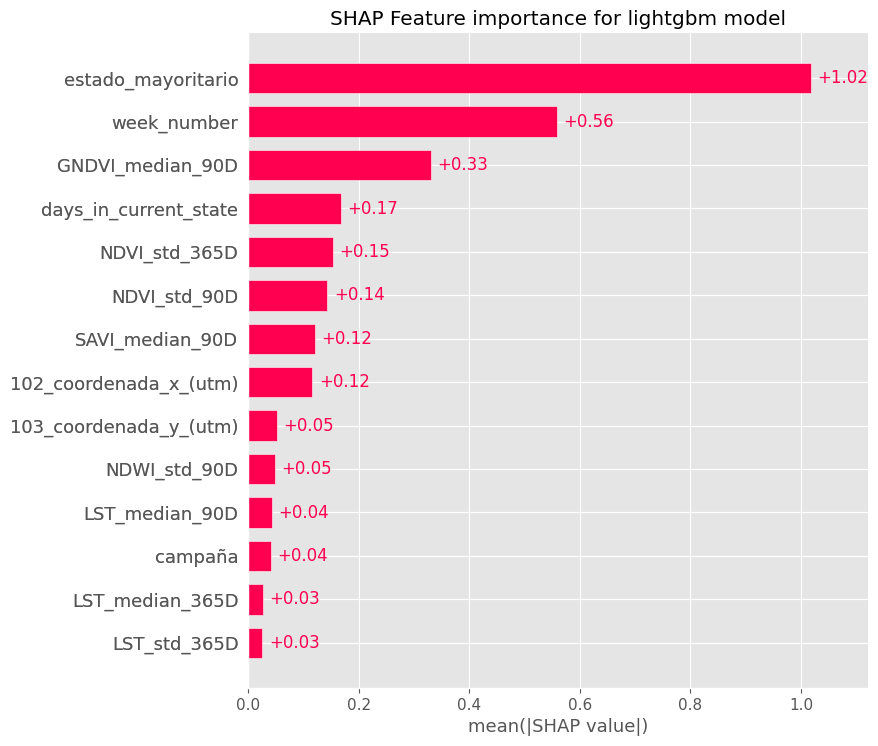

In [12]:
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": len(np.unique(y_train)),
    "num_trees": 100,

    "learning_rate": 0.1,
}
model_name = "lightgbm_top8_features"
model, eval_result = train_lightgbm_model(X_train, y_train, X_test, y_test, params)
evaluate_configuration_lightgbm(model, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
evaluation_metrics[model_name]["eval_result"] = eval_result
save_model(model, model_name, models)
shap_values = get_shap_values(model, X_test)
plot_shap_feature_importance(shap_values, top_n=30)

In [13]:

# selected_parcelas_cols = ["estado_mayoritario", "week_number","days_in_current_state", "102_coordenada_x_(utm)", "campaña", '103_coordenada_y_(utm)']
# selected_meteo_cols = ["GNDVI_median_90D", "NDVI_std_90D", "NDVI_std_365D", "SAVI_median_90D", 'NDWI_std_90D', "LST_median_90D", 'LST_std_365D', 'LST_median_365D']

# Features seleccionadas en el notebook
# selected_parcelas_cols = ['estado_mayoritario',
#  'week_number',
#  'days_in_current_state',
#  'campaña',
#  '102_coordenada_x_(utm)',
#  '103_coordenada_y_(utm)']

# selected_meteo_cols = [
#  'LST_mean_365D',
#  'LST_std_365D',
#  'LST_median_365D',
#  'LST']

# Alejandro
selected_parcelas_cols = ['week_number','days_in_current_state', 'estado_mayoritario'] + ['102_coordenada_x_(utm)', '103_coordenada_y_(utm)', 'days_in_previous_state', 'campaña']
selected_meteo_cols = ['SSM_max_90D', 'LST_mean_90D', 'NDVI_mean_90D', 'NDWI_min_90D',
                  'LST_std_90D', 'GNDVI_median_90D', 
                    'SSM_min_90D', 'GNDVI_min_90D',  'NDWI_median_90D', 
                    'LST_median_90D', 'NDWI_mean_90D',
                      'NDVI_median_90D', 'SSM_std_90D', 'SAVI_median_90D', 
                        'LST_count_90D', 'SAVI_median_365D']

X_train, y_train, X_test, y_test = preprocess_data_lightgbm(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 23
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lightgbm_selected_features_train:
INFO:src.metrics:accuracy: 0.8303040197358874
INFO:src.metrics:mse: 0.18387207952401682
INFO:src.metrics:precision_for_class: [0.91175278 0.7544348  0.69975616 0.8591224 ]
INFO:src.metrics:recall_for_class: [0.89620696 0.7912155  0.69445746 0.54306569]
INFO:src.metrics:f1_for_class: [0.90391304 0.77238753 0.69709674 0.66547406]
INFO:src.metrics:confusion_matrix:
[[51721  5835   152     3]
 [ 4894 29813  2939    34]
 [  109  3659  8896   146]
 [    3   210   726  1116]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lightgbm_selected_features_test:
INFO:src.metrics:accuracy: 0.7227102761634455
INFO:src.metrics:mse: 0.33319817993422535
INFO:src.metrics:precision_for_class: [0.83194986 0.6712948  0.50554995 0.24892704]
INFO:src.metrics:recall_for_class: [0.85654487 0.56718047 0.74859918 0.08033241]
INFO:src.metrics:f1_for_class: [0.84406823 0.61486137 0.60352357 0.12146597]
I

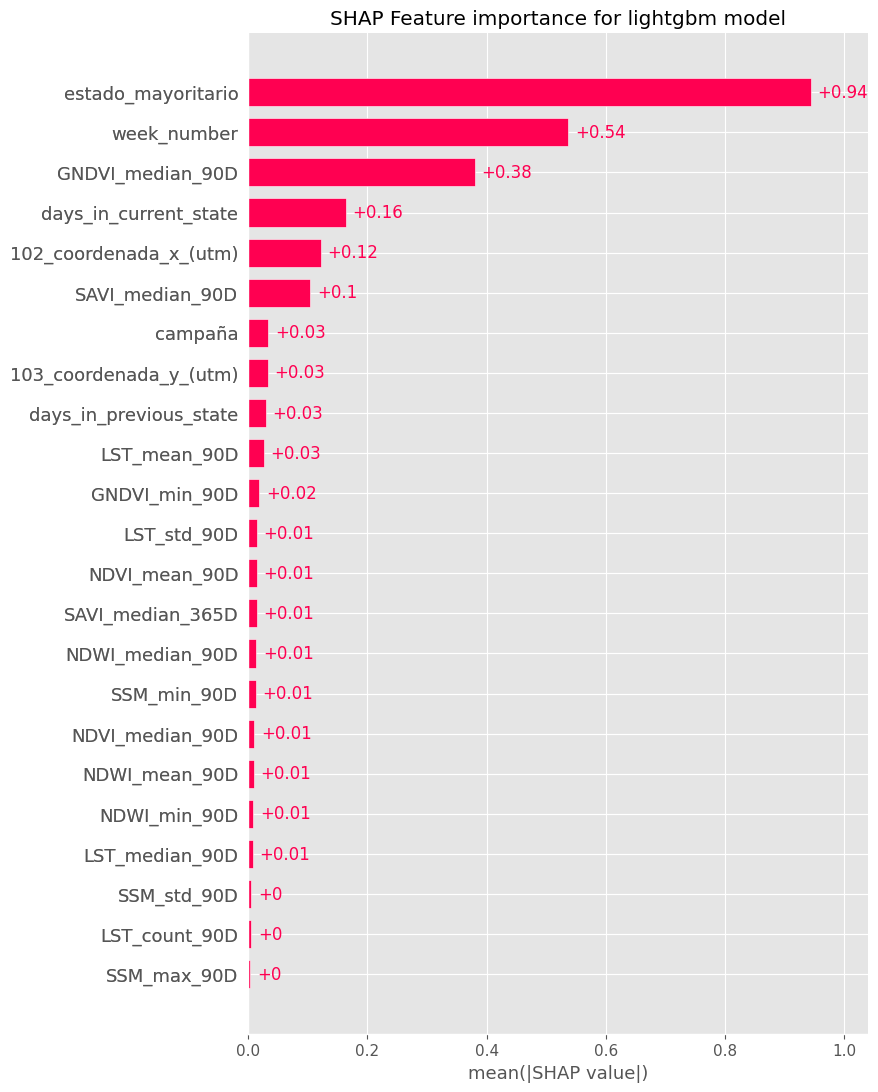

In [14]:
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": len(np.unique(y_train)),
    "num_trees": 100,

    "learning_rate": 0.1,
}
model_name = "lightgbm_selected_features"
model, eval_result = train_lightgbm_model(X_train, y_train, X_test, y_test, params)
evaluate_configuration_lightgbm(model, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
evaluation_metrics[model_name]["eval_result"] = eval_result
save_model(model, model_name, models)
shap_values = get_shap_values(model, X_test)
plot_shap_feature_importance(shap_values, top_n=30)

# Is the model learning or generalising?

In [15]:
n_trees = 100
test_lc = pd.DataFrame()
test_lc["multi_logloss"] = eval_result["valid_0"]["multi_logloss"]
test_lc["n_trees"] = list(range(n_trees))

train_lc = pd.DataFrame()
train_lc["multi_logloss"] = eval_result["training"]["multi_logloss"]
train_lc["n_trees"] = list(range(n_trees))

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

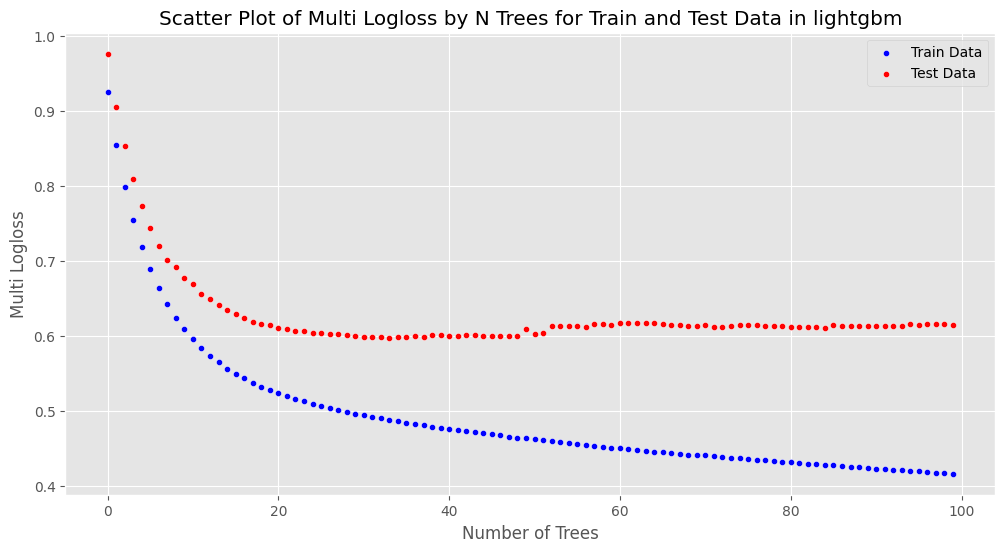

In [16]:
# Create the figure and adjust the figure size (width, height)
plt.figure(figsize=(12, 6))

# Plot the training data points
sns.scatterplot(x='n_trees_cat', y='multi_logloss', data=train_lc, color='blue', s=20, label='Train Data',)

# Plot the test data points
sns.scatterplot(x='n_trees_cat', y='multi_logloss', data=test_lc, color='red', s=20, label='Test Data')

# Add title and labels (optional)
plt.title('Scatter Plot of Multi Logloss by N Trees for Train and Test Data in lightgbm')
plt.xlabel('Number of Trees')
plt.ylabel('Multi Logloss')

# Show legend
plt.legend()

# Show the plot
plt.show()

Insights:
- We can cut the number of trees of lightgbm to 30, as more trees going further\
  is not learning.

# Training each type of model

In [29]:
baseline_parcelas = generate_target(df_parcelas)
baseline_train_df, baseline_test_df = train_test_split(
    baseline_parcelas, split_year=2021, max_year=2022
)
baseline_result = baseline(baseline_train_df, baseline_test_df, "target")[
    ["codparcela", "fecha", "target", "y_pred"]
]
evaluation_metrics["baseline"] = {
    "test": evaluate_classification(
        baseline_result["target"], baseline_result["y_pred"].round()
    )
}
log_metrics("baseline", evaluation_metrics["baseline"]["test"])

INFO:src.metrics:Computed Metrics for baseline:
INFO:src.metrics:accuracy: 0.6591431274496553
INFO:src.metrics:mse: 0.4575393071135739
INFO:src.metrics:precision_for_class: [0.75273694 0.5095332  0.62638581 0.        ]
INFO:src.metrics:recall_for_class: [0.83945234 0.52857727 0.42211431 0.        ]
INFO:src.metrics:f1_for_class: [0.79373325 0.51888056 0.50435171 0.        ]
INFO:src.metrics:confusion_matrix:
[[9626 1799   42    0]
 [2948 3875  508    0]
 [ 200 1347 1130    0]
 [  14  584  124    0]]
INFO:src.metrics:----------------------------------


In [30]:
selected_parcelas_cols = ['week_number','days_in_current_state', 'estado_mayoritario'] + ['102_coordenada_x_(utm)', '103_coordenada_y_(utm)', 'days_in_previous_state', 'campaña']
selected_meteo_cols = ['SSM_max_90D', 'LST_mean_90D', 'NDVI_mean_90D', 'NDWI_min_90D',
                  'LST_std_90D', 'GNDVI_median_90D', 
                    'SSM_min_90D', 'GNDVI_min_90D',  'NDWI_median_90D', 
                    'LST_median_90D', 'NDWI_mean_90D',
                      'NDVI_median_90D', 'SSM_std_90D', 'SAVI_median_90D', 
                        'LST_count_90D', 'SAVI_median_365D']

X_train, y_train, X_test, y_test = preprocess_data(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    model_name = f"lr_l2_selected_features_c_{c}"
    lr = Pipeline(
        [
            ("standard_scaler", StandardScaler()),
            ("lr", LogisticRegression(penalty="l2", C=c, multi_class='multinomial', solver='saga')),
        ]
    )
    lr.fit(X_train, y_train)
    evaluate_configuration(lr, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
    save_model(lr, model_name, models)

INFO:src.metrics:Computed Metrics for lr_l2_selected_features_c_1e-08_train:
INFO:src.metrics:accuracy: 0.5234272964736613
INFO:src.metrics:mse: 0.9742326948193296
INFO:src.metrics:precision_for_class: [0.5234273 0.        0.        0.       ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68717069 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[57711     0     0     0]
 [37680     0     0     0]
 [12810     0     0     0]
 [ 2055     0     0     0]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lr_l2_selected_features_c_1e-08_test:
INFO:src.metrics:accuracy: 0.5166013425237644
INFO:src.metrics:mse: 1.1054196513042303
INFO:src.metrics:precision_for_class: [0.51660134 0.         0.         0.        ]
INFO:src.metrics:recall_for_class: [1. 0. 0. 0.]
INFO:src.metrics:f1_for_class: [0.68126188 0.         0.         0.        ]
INFO:src.metrics:confusion_matrix:
[[11467     0     0     0]

## Random Forest Trees

In [32]:
n_trees_grid = [5, 25, 50, 100, 250]

for n_trees in n_trees_grid:
    model_name = f"rf_selected_features_trees_{n_trees}"

    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train, y_train)

    evaluate_configuration(rf, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
    save_model(rf, model_name, models)

INFO:src.metrics:Computed Metrics for rf_selected_features_trees_5_train:
INFO:src.metrics:accuracy: 0.9773436366274851
INFO:src.metrics:mse: 0.02762661442461181
INFO:src.metrics:precision_for_class: [0.9865285  0.96689335 0.96515236 0.98702001]
INFO:src.metrics:recall_for_class: [0.98975932 0.9735138  0.94699454 0.88807786]
INFO:src.metrics:f1_for_class: [0.98814127 0.97019228 0.95598723 0.93493852]
INFO:src.metrics:confusion_matrix:
[[57120   573    18     0]
 [  714 36682   279     5]
 [   59   601 12131    19]
 [    7    82   141  1825]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for rf_selected_features_trees_5_test:
INFO:src.metrics:accuracy: 0.6453574807406406
INFO:src.metrics:mse: 0.48402937333873947
INFO:src.metrics:precision_for_class: [0.75395249 0.51604874 0.46034215 0.16666667]
INFO:src.metrics:recall_for_class: [0.82759222 0.53730733 0.33171461 0.01108033]
INFO:src.metrics:f1_for_class: [0.78905795 0.52646351 0.38558402 0.0207792

## Lightgbm model

In [33]:
# Alejandro Logistic Regression
selected_parcelas_cols = ['week_number','days_in_current_state', 'estado_mayoritario'] + ['102_coordenada_x_(utm)', '103_coordenada_y_(utm)', 'days_in_previous_state', 'campaña']
selected_meteo_cols = ['SSM_max_90D', 'LST_mean_90D', 'NDVI_mean_90D', 'NDWI_min_90D',
                  'LST_std_90D', 'GNDVI_median_90D', 
                    'SSM_min_90D', 'GNDVI_min_90D',  'NDWI_median_90D', 
                    'LST_median_90D', 'NDWI_mean_90D',
                      'NDVI_median_90D', 'SSM_std_90D', 'SAVI_median_90D', 
                        'LST_count_90D', 'SAVI_median_365D']

X_train, y_train, X_test, y_test = preprocess_data_lightgbm(
    columns_parcela=selected_parcelas_cols, columns_meteo=selected_meteo_cols
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 110256, number of used features: 23
[LightGBM] [Info] Start training from score -0.647357
[LightGBM] [Info] Start training from score -1.073675
[LightGBM] [Info] Start training from score -2.152579
[LightGBM] [Info] Start training from score -3.982529


INFO:src.metrics:Computed Metrics for lightgbm_selected_features_train:
INFO:src.metrics:accuracy: 0.7878754897692642
INFO:src.metrics:mse: 0.23434552314613263
INFO:src.metrics:precision_for_class: [0.88783865 0.69749668 0.62055242 0.80990783]
INFO:src.metrics:recall_for_class: [0.87563896 0.73872081 0.60858704 0.34209246]
INFO:src.metrics:f1_for_class: [0.8816966  0.71751711 0.61451149 0.48101266]
INFO:src.metrics:confusion_matrix:
[[50534  6935   240     2]
 [ 6243 27835  3581    21]
 [  136  4736  7796   142]
 [    5   401   946   703]]
INFO:src.metrics:----------------------------------
INFO:src.metrics:Computed Metrics for lightgbm_selected_features_test:
INFO:src.metrics:accuracy: 0.7342884173536964
INFO:src.metrics:mse: 0.2923368022705771
INFO:src.metrics:precision_for_class: [0.84592384 0.63634044 0.57157605 0.38554217]
INFO:src.metrics:recall_for_class: [0.83884189 0.6802619  0.62047068 0.04432133]
INFO:src.metrics:f1_for_class: [0.84236798 0.65756857 0.5950206  0.07950311]
IN

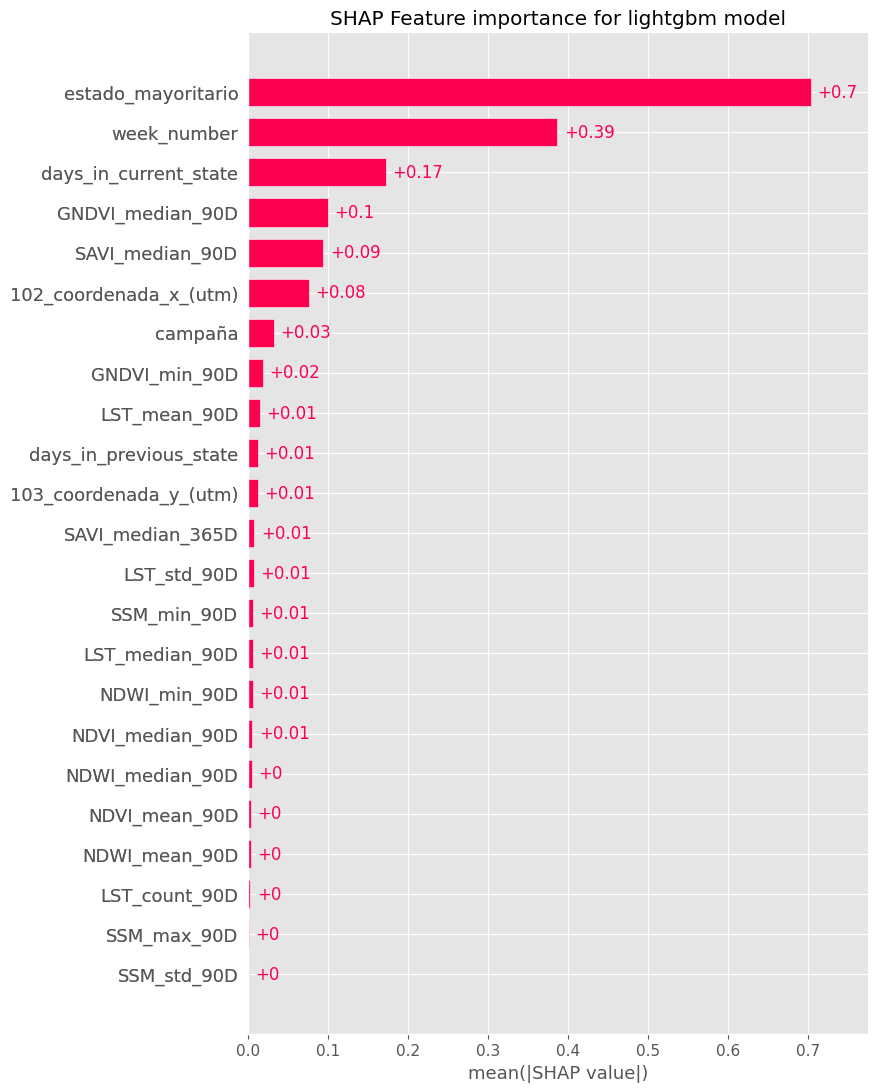

In [34]:
n_trees = 30
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": len(np.unique(y_train)),
    "num_trees": n_trees,

    "learning_rate": 0.1,
}
model_name = "lightgbm_selected_features"
model, eval_result = train_lightgbm_model(X_train, y_train, X_test, y_test, params)
evaluate_configuration_lightgbm(model, model_name, X_train, y_train, X_test, y_test, evaluation_metrics)
evaluation_metrics[model_name]["eval_result"] = eval_result
save_model(model, model_name, models)
shap_values = get_shap_values(model, X_test)
plot_shap_feature_importance(shap_values, top_n=30)

### Learning curve of lightgbm

In [35]:
test_lc = pd.DataFrame()
test_lc["multi_logloss"] = eval_result["valid_0"]["multi_logloss"]
test_lc["n_trees"] = list(range(n_trees))

train_lc = pd.DataFrame()
train_lc["multi_logloss"] = eval_result["training"]["multi_logloss"]
train_lc["n_trees"] = list(range(n_trees))

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

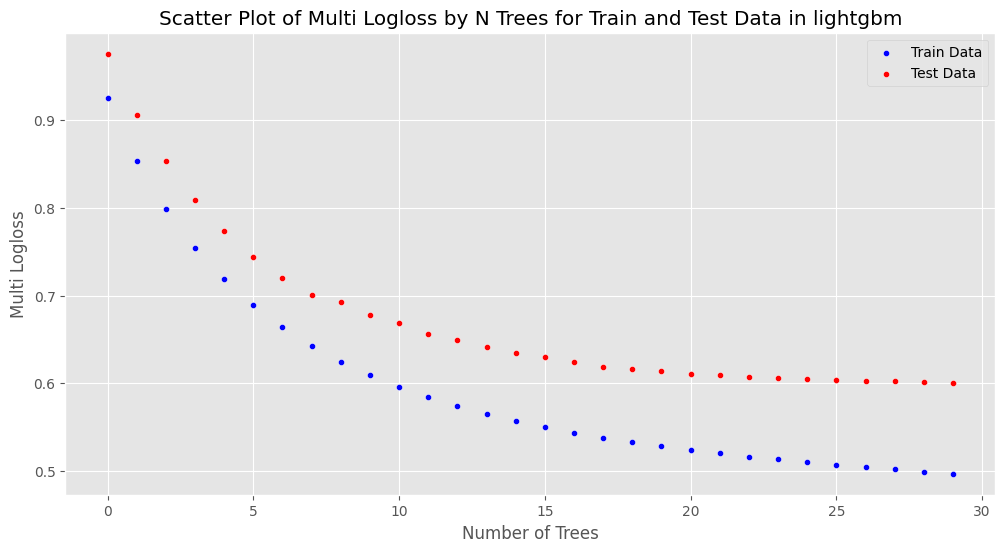

In [36]:
# Create the figure and adjust the figure size (width, height)
plt.figure(figsize=(12, 6))

# Plot the training data points
sns.scatterplot(x='n_trees_cat', y='multi_logloss', data=train_lc, color='blue', s=20, label='Train Data',)

# Plot the test data points
sns.scatterplot(x='n_trees_cat', y='multi_logloss', data=test_lc, color='red', s=20, label='Test Data')

# Add title and labels (optional)
plt.title('Scatter Plot of Multi Logloss by N Trees for Train and Test Data in lightgbm')
plt.xlabel('Number of Trees')
plt.ylabel('Multi Logloss')

# Show legend
plt.legend()

# Show the plot
plt.show()

# Comparison of models

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined lightgbm_test_metrics and baseline_test_metrics dictionaries
baseline_test_metrics = evaluation_metrics["baseline"]["test"]
lr_l2_test_metrics = evaluation_metrics["lr_l2_selected_features_c_0.0001"]["test"]
rf_test_metrics = evaluation_metrics["rf_selected_features_trees_250"]["test"]
lightgbm_test_metrics = evaluation_metrics["lightgbm_selected_features"]["test"]

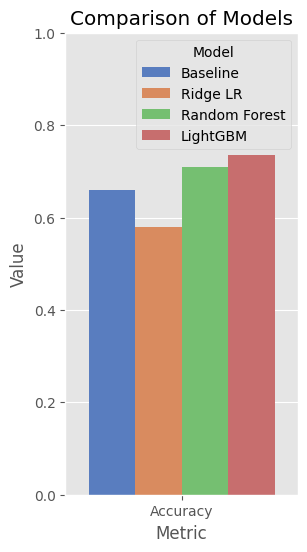

In [48]:
# Define the data
data = pd.DataFrame(
    {
        'Model': ['Baseline', "Ridge LR", "Random Forest", "LightGBM"],
        "Accuracy": [
            baseline_test_metrics["accuracy"],
            lr_l2_test_metrics["accuracy"],
            rf_test_metrics["accuracy"],
            lightgbm_test_metrics["accuracy"],
        ],
    }
)

# Melt the dataframe to long format
data_melted = data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(3, 6))
sns.barplot(data=data_melted, x="Metric", y="Score", hue="Model", palette="muted")

# Add labels and title
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Comparison of Models")
plt.legend(title="Model")
plt.ylim(0, 1.0)
# Show plot
plt.show()

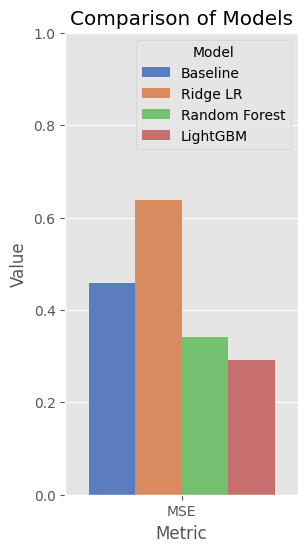

In [49]:
data = pd.DataFrame(
    {
        'Model': ['Baseline', "Ridge LR", "Random Forest", "LightGBM"],
        "MSE": [
            baseline_test_metrics["mse"],
            lr_l2_test_metrics["mse"],
            rf_test_metrics["mse"],
            lightgbm_test_metrics["mse"],
        ],
    }
)
# Melt the dataframe to long format
data_melted = data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(3, 6))
sns.barplot(data=data_melted, x="Metric", y="Score", hue="Model", palette="muted")

# Add labels and title
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Comparison of Models")
plt.legend(title="Model")
plt.ylim(0, 1.0)
# Show plot
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


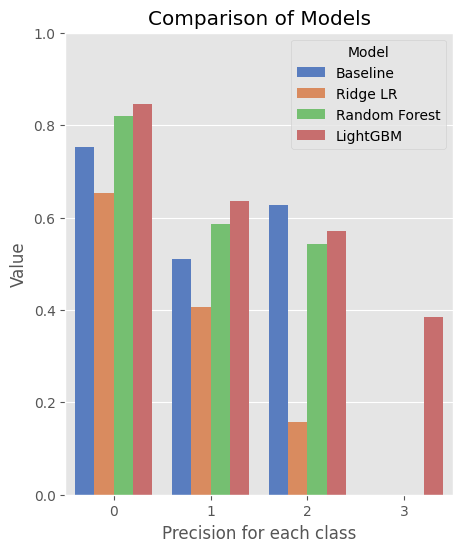

In [50]:
data = pd.DataFrame(
    {
        "Model": ["Baseline", "Ridge LR", "Random Forest", "LightGBM"],
        "0": [
            baseline_test_metrics["precision_for_class"][0],
            lr_l2_test_metrics["precision_for_class"][0],
            rf_test_metrics["precision_for_class"][0],
            lightgbm_test_metrics["precision_for_class"][0],
        ],
        "1": [
            baseline_test_metrics["precision_for_class"][1],
            lr_l2_test_metrics["precision_for_class"][1],
            rf_test_metrics["precision_for_class"][1],
            lightgbm_test_metrics["precision_for_class"][1],
        ],
        "2": [
            baseline_test_metrics["precision_for_class"][2],
            lr_l2_test_metrics["precision_for_class"][2],
            rf_test_metrics["precision_for_class"][2],
            lightgbm_test_metrics["precision_for_class"][2],
        ],
        "3": [
            baseline_test_metrics["precision_for_class"][3],
            lr_l2_test_metrics["precision_for_class"][3],
            rf_test_metrics["precision_for_class"][3],
            lightgbm_test_metrics["precision_for_class"][3],
        ],
    }
)

# Melt the dataframe to long format
data_melted = data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(5, 6))
sns.barplot(data=data_melted, x="Metric", y="Score", hue="Model", palette="muted")

# Add labels and title
plt.xlabel("Precision for each class")
plt.ylabel("Value")
plt.title("Comparison of Models")
plt.legend(title="Model")
plt.ylim(0, 1.0)
# Show plot
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


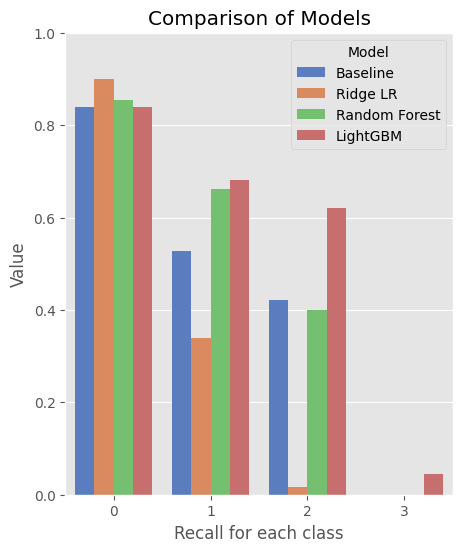

In [51]:
data = pd.DataFrame(
    {
        "Model": ["Baseline", "Ridge LR", "Random Forest", "LightGBM"],
        "0": [
            baseline_test_metrics["recall_for_class"][0],
            lr_l2_test_metrics["recall_for_class"][0],
            rf_test_metrics["recall_for_class"][0],
            lightgbm_test_metrics["recall_for_class"][0],
        ],
        "1": [
            baseline_test_metrics["recall_for_class"][1],
            lr_l2_test_metrics["recall_for_class"][1],
            rf_test_metrics["recall_for_class"][1],
            lightgbm_test_metrics["recall_for_class"][1],
        ],
        "2": [
            baseline_test_metrics["recall_for_class"][2],
            lr_l2_test_metrics["recall_for_class"][2],
            rf_test_metrics["recall_for_class"][2],
            lightgbm_test_metrics["recall_for_class"][2],
        ],
        "3": [
            baseline_test_metrics["recall_for_class"][3],
            lr_l2_test_metrics["recall_for_class"][3],
            rf_test_metrics["recall_for_class"][3],
            lightgbm_test_metrics["recall_for_class"][3],
        ],
    }
)

# Melt the dataframe to long format
data_melted = data.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(5, 6))
sns.barplot(data=data_melted, x="Metric", y="Score", hue="Model", palette="muted")

# Add labels and title
plt.xlabel("Recall for each class")
plt.ylabel("Value")
plt.title("Comparison of Models")
plt.legend(title="Model")
plt.ylim(0, 1.0)
# Show plot
plt.show()